## Pre-requisites

None

## Instructions

Households surveyed by DHS and LSMS are grouped into clusters (roughly villages). Our goal is to train models to predict the average cluster wealth-index given a satellite image of the cluster. To train our models, we assign the clusters into training (`train`), validation (`val`), and test (`test`) splits.

However, we do not arbitrarily assign clusters to splits because many clusters are located very close to each other such that their satellite images overlap. If one cluster was put in `train` and a nearby cluster was put into `test`, this may constitute "peaking" at the test set. This is not what we want. Instead, we want our model to be generalizable, able to estimate the cluster wealth-index in grographic regions that the model has not necessarily seen before.

Thus, we have to take special care that the satellite images between splits do not overlap. We do this through 2 separate approaches: "out-of-country" and "in-country". For "**out-of-country**" splits, we assign entire countries to a split, so naturally there is no overlap between splits. For "**in-country**" splits, we allow different clusters within the same country to be assigned to different splits, taking care that their satellite images have no overlap. **The point of this notebook is to create the in-country splits.**

Because the survey data is fairly limited (~20K DHS clusters, ~3K LSMS clusters), we actually use cross-validated training. We assign the clusters to 1 of 5 folds labeled `['A', 'B', 'C', 'D', 'E']` such that the folds are non-overlapping. Given the 5 folds, we create 5 different sets of train/val/test splits, where each set is labeled by the name of its `test` fold:

```
A) test  = {A}
   val   = {B}
   train = {C, D, E}

B) test  = {B}
   val   = {C}
   train = {D, E, A}

...

E) test  = {E}
   val   = {A}
   train = {B, C, D}
```

This notebook creates 2 Python pickle files: `data/dhs_incountry_folds.pkl` and `data/lsms_incountry_folds.pkl`. Each of these files contains a pickle'd Python dictionary which can be loaded as follows:

```python
with open('data/dhs_incountry_folds.pkl', 'rb') as f:
    dhs_incountry_folds = pickle.load(f)
```

The dictionary has type `dict[str, dict[str, np.ndarray]` such that `dhs_incountry_folds[f][s]` returns an array of indices corresponding to split `s` of fold `f`. The indices correspond to 0-indexed rows from `data/dhs_clusters.csv` and `data/lsms_clusters.csv`.

```python
dhs_incountry_folds = {
    'A': {'test':  array([   28,    29,    35, ..., 19662, 19664, 19667]),
          'train': array([    2,     3,     4, ..., 19663, 19665, 19668]),
          'val':   array([    0,     1,     8, ..., 19643, 19659, 19666])},
    ...
    'E': {'test':  array([    2,     3,     4, ..., 19653, 19656, 19663]),
          'train': array([    0,     1,     6, ..., 19665, 19666, 19668]),
          'val':   array([   28,    29,    35, ..., 19662, 19664, 19667])}}
```

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Pre-requisites" data-toc-modified-id="Pre-requisites-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Pre-requisites</a></span></li><li><span><a href="#Instructions" data-toc-modified-id="Instructions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Instructions</a></span></li><li><span><a href="#Imports-and-Constants" data-toc-modified-id="Imports-and-Constants-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Imports and Constants</a></span></li><li><span><a href="#Calculate-Locations-Statistics" data-toc-modified-id="Calculate-Locations-Statistics-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Calculate Locations Statistics</a></span></li><li><span><a href="#Create-In-country-Folds" data-toc-modified-id="Create-In-country-Folds-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Create In-country Folds</a></span></li></ul></div>

## Imports and Constants

In [1]:
# change directory to repo root
%cd '../'
%load_ext autoreload
%autoreload 2

/media/matthieu/LaCie/2-mpa


In [2]:
import numpy as np
import pandas as pd

from create_folds import (
    create_folds,
    create_split_folds,
    save_folds,
    verify_folds)

In [3]:
!ls data

geometry_less_dataset.csv  landsat_tif	     wealth_index.csv
landsat_7less		   mpa_geometry.csv


In [4]:
FOLDS = ['A', 'B', 'C', 'D', 'E']
MIN_DIST = 0.092841  # see how this value is computed below

## Calculate Locations Statistics

We want to group our surveyed clusters into 5 folds such that there is absolutely no overlap between the satellite images from different folds. In other words, if any part of an image *i1* covers the same geographic area as another image *i2*, then we must put the clusters corresponding to *i1* and *I2* into the same fold.

We have the (lat, lon) coordinates for each cluster, so our approach is to determine the threshold "radius" around each cluster that would be considered part of the same fold. We know that our satellite images have 30m/px resolution, and our models use `224*224px` center crops of the images. This means that each image has a side length of 30m/px * 224px = **6.72km**. Thus, we try to convert 6.72km to degrees (lat, lon).

Note that the degrees longitude corresponding to a given East-West distance (in meters) changes depends on the latitude. Thus, converting between traditional units of distance (e.g., meters) and degrees lat/lon is non-trivial. This section calculates the maximum degrees (lat, lon) equivalent to 6.72km at the location of any cluster in our dataset.

The results computed should match the following:

|                                                | DHS        | LSMS
|-----------------------------------------------:|-----------:|-----------:|
| minimum latitude                               | -30.588811 | -16.985500
| maximum latitude                               |  16.580605 |  14.455962
| minimum longitude                              | -17.478474 |   2.969085
| maximum longitude                              |  47.007920 |  43.870658
| maximum image side-length in degrees latitude  |   0.060570 |   0.060570
| maximum image side-length in degrees longitude |   0.070361 |   0.063333

This means that for the purpose of deciding image overlap, we assume each satellite image to have width=0.070361° and height=0.060570°. (We take the maximum across the DHS and LSMS datasets.) Because images may overlap in corners, we consider any two images within $$\sqrt{0.060570^2 + 0.070361^2} = 0.092841$$ degrees (lat, lon) to be overlapping. This is the value of the `MIN_DIST` constant above.

In [5]:
RADIUS_EARTH = 6356.7523  # in km, polar radius of Earth

def get_lon_for_distance(lat: float, d: float) -> float:
    '''Calculates the degrees longitude for some East-West distance at a given latitude.

    Makes (imperfect) assumption that Earth is a perfect sphere.
    Uses the smaller polar radius (instead of equatorial radius), so
        actual degrees longitude <= returned value

    Args
    - lat: float, latitude in degrees
    - d: float, distance in km

    Returns
    - lon: float, approximate degrees longitude
    '''
    lat = np.abs(lat) * np.pi / 180.0  # convert to radians
    r = RADIUS_EARTH * np.cos(lat)  # radius at the given lat
    lon = d / r
    lon = lon * 180.0 / np.pi  # convert to degrees
    return lon

def get_lat_for_distance(d: float) -> float:
    '''Calculates the degrees latitude for some North-South distance.

    Makes (incorrect) assumption that Earth is a perfect sphere.
    Uses the smaller polar radius (instead of equatorial radius), so
        actual degrees latitude <= returned value

    Args
    - d: float, distance in km

    Returns
    - lat: float, approximate degrees latitude
    '''
    lat = d / RADIUS_EARTH  # in radians
    lat = lat * 180.0 / np.pi  # convert to degrees
    return lat

def print_loc_stats(locs: np.ndarray) -> None:
    '''
    Args
    - locs: np.array, shape [N, 2], each row is [lat, lon] in degrees
        assumes lat values are + for N, - for S
        assumes lon values are + for E, - for W
    '''
    min_lat, min_lon = np.min(locs, axis=0)
    max_lat, max_lon = np.max(locs, axis=0)
    print(f'Lat. min: {min_lat:.6f}, max: {max_lat:.6f}')
    print(f'Lon. min: {min_lon:.6f}, max: {max_lon:.6f}')
    print()

    # get maximum lat/lon side-lengths for a 224x224 pixel image at 30m / px
    side_distance = 224 * 30 / 1000
    farthest_lat = max(abs(min_lat), abs(max_lat))
    side_lat = get_lat_for_distance(d=side_distance)
    side_lon = get_lon_for_distance(lat=farthest_lat, d=side_distance)
    print(f'maximum side_lat: {side_lat:.6f}')
    print(f'maximum side_lon: {side_lon:.6f}')

In [6]:
dhs_df = pd.read_csv('data/geometry_less_dataset.csv', float_precision='high', index_col=False)
dhs_locs = dhs_df[['lat', 'lon']].values
print_loc_stats(dhs_locs)

Lat. min: -30.588812, max: 20.175791
Lon. min: -17.498482, max: 50.313255

maximum side_lat: 0.060570
maximum side_lon: 0.070361


In [7]:
lsms_df = pd.read_csv('data/geometry_less_dataset.csv', float_precision='high', index_col=False)
lsms_locs = lsms_df[['lat', 'lon']].values
print_loc_stats(lsms_locs)

Lat. min: -30.588812, max: 20.175791
Lon. min: -17.498482, max: 50.313255

maximum side_lat: 0.060570
maximum side_lon: 0.070361


## Create In-country Folds

Using the DBSCAN algorithm, we group the survey clusters such that each group has a minimum distance of `MIN_DIST` from every other group. These are called "in-country" folds because different clusters from same country may be split across different folds. This is in contrast to the "out-of-country" (OOC) folds where the countries themselves are assigned to different folds.

num clusters: 2862
num outliers: 5322
max cluster size (excl. outliers): 1756


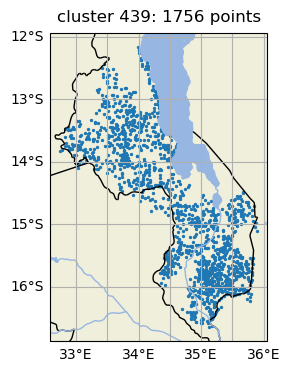

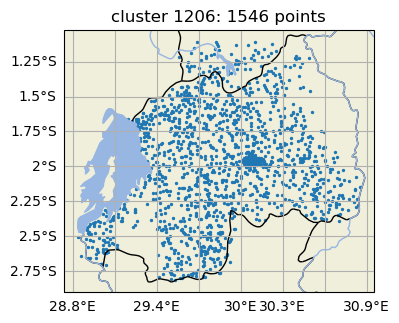

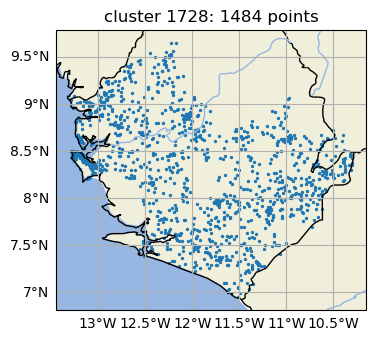

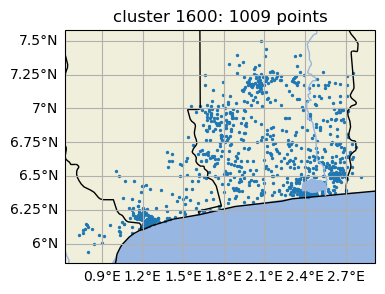

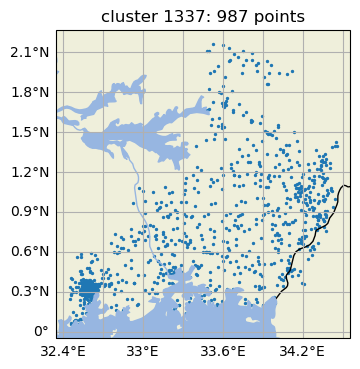

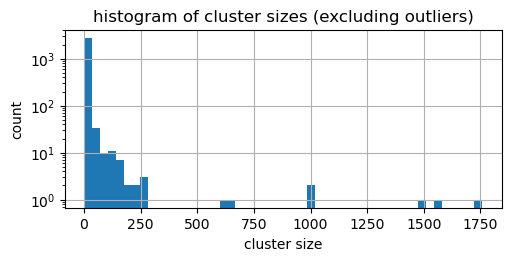

Size of each fold
{'A': 6459, 'B': 6458, 'C': 6458, 'D': 6458, 'E': 6458}
Minimum distance between each pair of folds
A B 0.09288848701489168
A C 0.09297049696649295
A D 0.09299250333135942
A E 0.0928555428929316
B C 0.09300533487256615
B D 0.09324975630210947
B E 0.09291808590484692
C D 0.09288223659731785
C E 0.09297267429215215
D E 0.09299061815336714


In [8]:
dhs_incountry_test_folds = create_folds(
    locs=dhs_locs,
    min_dist=MIN_DIST,
    fold_names=FOLDS,
    plot_largest_clusters=5)

verify_folds(
    folds=dhs_incountry_test_folds,
    locs=dhs_locs,
    min_dist=MIN_DIST,
    max_index=len(dhs_locs))

dhs_incountry_folds = create_split_folds(
    test_folds=dhs_incountry_test_folds,
    fold_names=FOLDS)

save_folds(
    folds_path='data/dhs_incountry_folds.pkl',
    folds=dhs_incountry_folds,
    check_exists=True)